## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
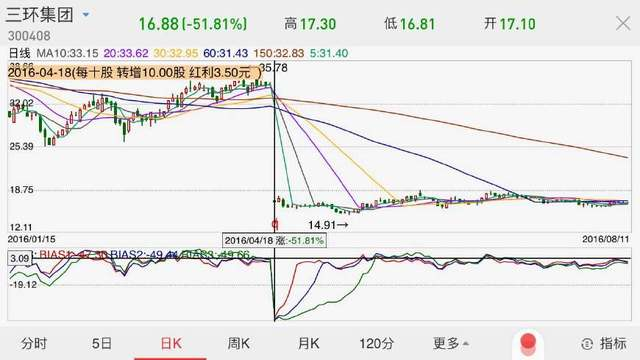

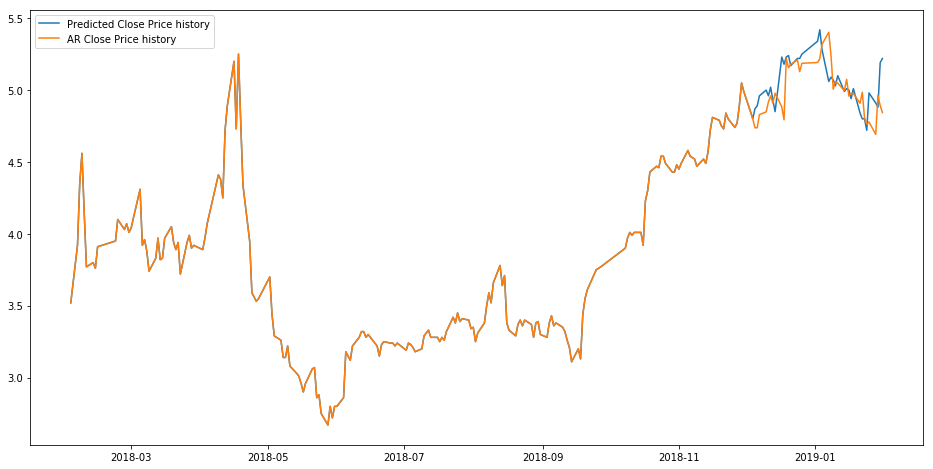

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [1]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [10]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        # 带有上标（变音符）的那种字母，有两种表示方式：一是作为一个整体字符；二是拆为两个字符，字母本身+变音符
        # NFD意思是按照方式二进行标准化处理。
        c for c in unicodedata.normalize('NFD', s)
        # 拆出来的字符要去掉Mn类型的字符，变音符包含在这类里
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


In [234]:
print(string.ascii_letters)
print(ascii(unicodedata.normalize('NFD', 'Ślusàrski')))
print(unicodedata.category('Ś'))
print(unicodedata.category('\u0301'))
print('**********************')
print(ascii('S'))
print(ascii('Ś'))
print('\u015a')
print('S\u0301')
print(ascii(unicodedata.normalize('NFD', 'Ś')))
print(ascii(unicodedata.normalize('NFKD', 'Ś')))
print(ascii(unicodedata.normalize('NFC', 'Ś')))
print(ascii(unicodedata.normalize('NFKC', 'Ś')))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
'S\u0301lusa\u0300rski'
Lu
Mn
**********************
'S'
'\u015a'
Ś
Ś
'S\u0301'
'S\u0301'
'\u015a'
'\u015a'


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [235]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    # os.path.basename() 获取完整路径中的文件名
    # os.path.splitext() 按最后一个句号点把文件名拆分为文件名和扩展名，list形式
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [236]:
os.path.basename('data/names\\Arabic.txt')
os.path.splitext('Arabic.txt.dafadf')

('Arabic.txt', '.dafadf')

In [237]:
print(n_categories)
print(all_categories)

18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [21]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [241]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))
print(line_to_tensor('Jones').size())
print(line_to_tensor('Jones'))

35
torch.Size([5, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

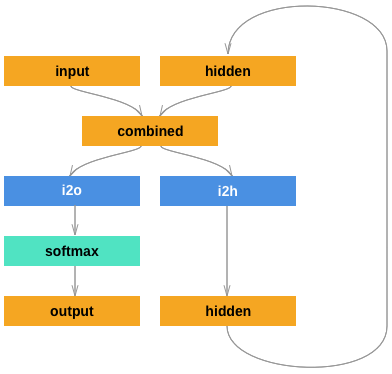

In [242]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        # 调用父类的初始化函数，python3中可以简写为
        # super().__init__()
        
        print('RNN')

        self.hidden_size = hidden_size

        # 定义网络节点的结构
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    # forward函数是必须定义的，会被父类中的函数调用的
    def forward(self, input, hidden):
        # 在第1维上把数据连接
        combined = torch.cat((input, hidden), 1)
        # 定义数据流向
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [243]:
type(nn.Linear(10, 20))

torch.nn.modules.linear.Linear

In [245]:
rnn = RNN(n_letters, n_hidden, n_categories)

RNN


### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [246]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

# 调用RNN父类中定义的__call__()函数
output, next_hidden = rnn(input, hidden)

In [247]:
output

tensor([[-2.8880, -2.9559, -2.8836, -2.8865, -2.8443, -2.8418, -2.8823, -2.9222,
         -2.9688, -2.9475, -2.8294, -2.8443, -2.8825, -2.8907, -2.9055, -2.9915,
         -2.8853, -2.7986]], grad_fn=<LogSoftmaxBackward>)

In [248]:
next_hidden

tensor([[-0.0180,  0.0637,  0.0780, -0.0934,  0.0864,  0.0179, -0.0139, -0.0260,
          0.0763, -0.0321, -0.0732, -0.0678, -0.0306,  0.0698, -0.0206, -0.0009,
          0.0963,  0.0312,  0.0270, -0.0978, -0.0284,  0.0780, -0.0513,  0.0006,
         -0.0949, -0.0063, -0.0666,  0.0063, -0.0421,  0.0043,  0.0623,  0.0942,
         -0.0832, -0.0642,  0.0071, -0.0813, -0.0084,  0.0718,  0.0022, -0.0991,
         -0.0150, -0.0206, -0.1171,  0.1079,  0.0486,  0.1271, -0.0015, -0.0118,
          0.0340, -0.0971, -0.0536, -0.0162,  0.0106,  0.0658, -0.0710, -0.0889,
          0.0733, -0.0710,  0.0051,  0.0956,  0.1133, -0.0675, -0.0147,  0.0827,
          0.0780,  0.0916,  0.0493,  0.1143,  0.0422, -0.0219, -0.0492, -0.0583,
          0.1197,  0.0051,  0.0654,  0.0523, -0.0130, -0.0305,  0.1018, -0.0188,
          0.0762,  0.0956,  0.0689, -0.0446,  0.0030, -0.0265, -0.0191, -0.0716,
          0.0234,  0.0967, -0.0227, -0.0927, -0.0086,  0.0777,  0.0324,  0.1092,
         -0.0444, -0.0548, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [250]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(input)
print(output)
print(type(output))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [251]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



In [252]:
t = torch.tensor([1,2,3,4,5,6,5,4,3])
t.topk(2)

torch.return_types.topk(
values=tensor([6, 5]),
indices=tensor([5, 4]))

对于刚刚产生的output，我们使用这个函数

In [253]:
print(category_from_output(output))

('Vietnamese', 17)


### 1.8 随机生成训练数据

In [254]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = German / line = Wetterman
category = French / line = Fabre
category = Polish / line = Rusnak
category = Scottish / line = Cunningham
category = Irish / line = Neil
category = Korean / line = Tsai 
category = French / line = Monette
category = German / line = Geiszler
category = Irish / line = Flanagan
category = Russian / line = Shakhorin


In [255]:
sample_trainning()

('Portuguese',
 'Delgado',
 tensor([13]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [256]:
line_tensor.size()

torch.Size([9, 1, 57])

### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [257]:
criterion = nn.CrossEntropyLoss()

In [298]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # 梯度需要初始化为0
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        # 调用父类的__call__()函数，在里面会调用forward()函数
        output, hidden = rnn(line_tensor[i], hidden)

    # 计算交叉熵损失函数
    loss = criterion(output, category_tensor)
    # 反向传播，计算梯度
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [299]:
import time
import math

n_iters = 100000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

learning_rate = 0.005
rnn = RNN(n_letters, n_hidden, n_categories)
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

RNN
1000 1% (0m 1s) 2.8297 Rosario / Italian ✗ (Portuguese)
2000 2% (0m 3s) 2.8166 Bartosz / Chinese ✗ (Polish)
3000 3% (0m 5s) 2.7509 Eberhardt / English ✗ (German)
4000 4% (0m 8s) 2.5844 Lobo / Portuguese ✓
5000 5% (0m 10s) 2.9895 Altena / Japanese ✗ (Dutch)
6000 6% (0m 12s) 2.5989 Nigro / Vietnamese ✗ (Italian)
7000 7% (0m 14s) 1.8812 Mathghamhain / Russian ✗ (Irish)
8000 8% (0m 17s) 1.0337 Yoo / Korean ✓
9000 9% (0m 19s) 2.3426 Escamilla / Italian ✗ (Spanish)
10000 10% (0m 22s) 2.8132 Clark / Japanese ✗ (English)
11000 11% (0m 24s) 1.0972 Chou / Korean ✓
12000 12% (0m 27s) 1.4456 Bilias / Greek ✓
13000 13% (0m 29s) 3.0289 Marfin / Arabic ✗ (Russian)
14000 14% (0m 32s) 2.8533 Ealham / Arabic ✗ (English)
15000 15% (0m 34s) 1.2688 Fei / Chinese ✓
16000 16% (0m 37s) 2.7835 Ise / Chinese ✗ (Japanese)
17000 17% (0m 39s) 1.3642 Ly / Vietnamese ✓
18000 18% (0m 42s) 1.5389 Morrison / Scottish ✓
19000 19% (0m 45s) 1.2548 Richter / German ✓
20000 20% (0m 48s) 2.4025 Brandt / French ✗ (German)

### 1.9 观察Loss的变化

In [300]:
all_losses

[2.8678945875167847,
 2.823887216091156,
 2.7933441665172576,
 2.7413142671585082,
 2.6269994837641715,
 2.5056830236315726,
 2.3859925177246333,
 2.32987050101161,
 2.25219318318367,
 2.1794310154691336,
 2.149001387625933,
 2.0868175345808266,
 2.064384396135807,
 2.0296953667104245,
 1.9975997349321841,
 1.9866339997947216,
 1.950269772656262,
 1.8966497162356972,
 1.9171517229117454,
 1.8783828734401613,
 1.8020665730834007,
 1.835181860037148,
 1.793312007702887,
 1.743534487016499,
 1.7789980860929937,
 1.7611975584179163,
 1.730772127930075,
 1.7502142869904638,
 1.7193504764921963,
 1.68992479054071,
 1.6063408654462545,
 1.6711968707465568,
 1.667671177672688,
 1.6044832741906867,
 1.635481897660764,
 1.584038106391672,
 1.573336709184572,
 1.5611971158729867,
 1.5654976543204393,
 1.6539652425874956,
 1.5899839765508659,
 1.5129639726597817,
 1.5580972559684887,
 1.4966546243502235,
 1.572706712409621,
 1.4630437961369753,
 1.4977215677658096,
 1.4663851482346655,
 1.48964511

In [301]:
%matplotlib inline

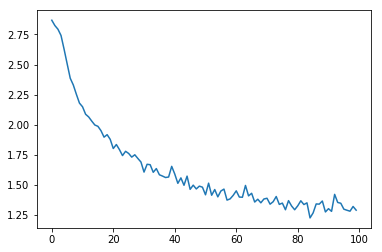

In [302]:
plt.plot(all_losses)

In [275]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Zhang')


> Dovesky
(-0.64) Czech
(-1.07) Russian
(-3.07) English

> Jackson
(-0.43) Scottish
(-1.72) English
(-2.82) Czech

> Satoshi
(-1.23) Arabic
(-1.64) Japanese
(-1.89) Italian

> Zhang
(-0.24) Chinese
(-1.68) Korean
(-4.81) Vietnamese


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

input和output的数据合并后，先经过一层Linear，然后再分别计算output和hidden

In [280]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # 调用父类的初始化函数，python3中可以简写为
        # super().__init__()

        print('RNN1')
        self.hidden_size = hidden_size

        # 定义网络节点的结构
        self.i2t = nn.Linear(input_size + hidden_size, 512)
        self.t2h = nn.Linear(512, hidden_size)
        self.t2o = nn.Linear(512, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    # forward函数是必须定义的，会被父类中的函数调用的
    def forward(self, input, hidden):
        # 在第1维上把数据连接
        combined = torch.cat((input, hidden), 1)
        # 定义数据流向
        t = self.i2t(combined)
        hidden = self.t2h(t)
        output = self.t2o(t)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

n_iters = 100000 # 这个数字你可以调大一些
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

learning_rate = 0.005
rnn = RNN1(n_letters, n_hidden, n_categories)
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

RNN1
5000 5% (0m 22s) 1.8892 Paitakes / Greek ✓
10000 10% (0m 50s) 1.9853 Alvarez / Dutch ✗ (Spanish)
15000 15% (1m 16s) 0.0685 Bertsimas / Greek ✓
20000 20% (1m 41s) 1.1656 Janvier / French ✓
25000 25% (2m 7s) 0.3667 Libkin / Russian ✓
30000 30% (2m 33s) 2.9864 Lee / Chinese ✗ (Korean)
35000 35% (2m 59s) 1.1999 Kamachi / Italian ✗ (Japanese)
40000 40% (3m 25s) 2.6931 Molloy / Scottish ✗ (Irish)
45000 45% (3m 52s) 0.8843 Chavarria / Spanish ✓
50000 50% (4m 17s) 0.3608 Rao / Chinese ✓
55000 55% (4m 42s) 4.2500 Gerges / Portuguese ✗ (Arabic)
60000 60% (5m 7s) 0.5899 Beauchene / French ✓
65000 65% (5m 33s) 3.7011 Ogtrop / English ✗ (Dutch)
70000 70% (5m 59s) 1.5180 Sommer / German ✓
75000 75% (6m 24s) 0.1341 Wojewodzki / Polish ✓
80000 80% (6m 49s) 0.7528 Hanabusa / Japanese ✓
85000 85% (7m 14s) 0.0537 Bilenkin / Russian ✓
90000 90% (7m 39s) 2.1251 Walker / German ✗ (Scottish)
95000 95% (8m 4s) 1.2715 Kalb / Arabic ✓
100000 100% (8m 30s) 0.9901 O'Gorman / Irish ✓


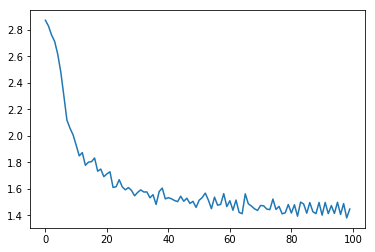

In [281]:
plt.plot(all_losses)

从loss曲线看，初期的收敛变快了，但稳定后的loss似乎比之前的还要大些

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

pytroch官方文档： https://pytorch.org/docs/stable/nn.html#recurrent-layers  
深入理解lstm及gru: https://zhuanlan.zhihu.com/p/34203833

## LSTM模型

In [303]:
# n_hidden = n_categories
n_hidden = 32
lstm = nn.LSTM(n_letters, n_hidden) 

In [284]:
n_letters

57

In [283]:
# 定义训练过程
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_lstm(category_tensor, line_tensor, hidden_size):
    lstm.zero_grad() #每次梯度必须清零
    h0 = torch.randn(1, 1, hidden_size)
    c0 = torch.randn(1, 1, hidden_size)
    for i in range(line_tensor.size()[0]): #iteration for each letter
        output, (h0,c0) = lstm(line_tensor[i].reshape(1,line_tensor.size()[1],line_tensor.size()[2]), (h0,c0))


    loss = criterion(c0[0], category_tensor) #CrossEntropy loss
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data) # p=p-learning_rate*p.grad

    return output, loss.item()

In [304]:
# 训练模型
import time
import math

n_iters = 100000 # 这个数字你可以调大一些
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses_lstm = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    #print("categort:{},line:{},c_tensor:{},l_tensor:{}".format(category, line, category_tensor, line_tensor))
    output, loss = train_lstm(category_tensor, line_tensor, n_hidden)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_lstm.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 17s) 3.2413 She / Japanese ✗ (Chinese)
10000 10% (0m 40s) 2.6329 Wardle / Greek ✗ (English)
15000 15% (1m 4s) 2.2706 Lac / Japanese ✗ (Vietnamese)
20000 20% (1m 27s) 2.6083 Mathieu / Japanese ✗ (French)
25000 25% (1m 49s) 2.1157 Sergeant / Italian ✗ (French)
30000 30% (2m 11s) 1.3733 Fortier / French ✓
35000 35% (2m 33s) 1.8015 Maslanka / Japanese ✗ (Polish)
40000 40% (2m 55s) 2.1183 Ly / Vietnamese ✓
45000 45% (3m 17s) 2.6937 Deschamps / Greek ✗ (French)
50000 50% (3m 39s) 2.9253 Marek / Portuguese ✗ (Polish)
55000 55% (4m 1s) 1.8324 Basurto / Italian ✗ (Portuguese)
60000 60% (4m 23s) 1.9736 Merlo / Italian ✓
65000 65% (4m 45s) 2.9228 Turaev / French ✗ (Russian)
70000 70% (5m 8s) 1.7755 Paterson / English ✗ (Scottish)
75000 75% (5m 31s) 1.6472 Tao / Vietnamese ✗ (Chinese)
80000 80% (5m 54s) 1.3127 Komatsu / Greek ✗ (Japanese)
85000 85% (6m 18s) 1.3850 Shi / Vietnamese ✗ (Chinese)
90000 90% (6m 41s) 1.5999 Youj / Vietnamese ✗ (Korean)
95000 95% (7m 4s) 2.5098 Cline / French

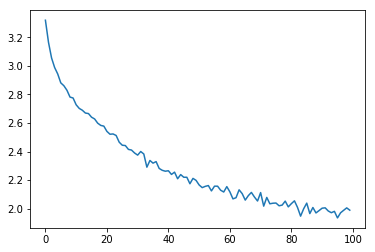

In [305]:
plt.plot(all_losses_lstm)

收敛明显变慢了

## GRU模型

In [306]:
# n_hidden = n_categories
n_hidden = 32
gru = nn.GRU(n_letters, n_hidden) 

In [307]:
#Define training process
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_gru(category_tensor, line_tensor, hidden_size):
    gru.zero_grad() #每次梯度必须清零
    h0 = torch.randn(1, 1, hidden_size)
    for i in range(line_tensor.size()[0]): #iteration for each letter
        output, h0 = gru(line_tensor[i].reshape(1,line_tensor.size()[1],line_tensor.size()[2]), h0)

    loss = criterion(h0[0], category_tensor) #CrossEntropy loss
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in gru.parameters():
        p.data.add_(-learning_rate, p.grad.data) # p=p-learning_rate*p.grad

    return output, loss.item()

In [308]:
#Train the model
import time
import math

n_iters = 100000 # 这个数字你可以调大一些
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses_gru = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    #print("categort:{},line:{},c_tensor:{},l_tensor:{}".format(category, line, category_tensor, line_tensor))
    output, loss = train_gru(category_tensor, line_tensor, n_hidden)
    current_loss += loss

    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_gru.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 16s) 3.2144 Aita / English ✗ (Italian)
10000 10% (0m 39s) 2.8991 Prosdocimi / Russian ✗ (Italian)
15000 15% (1m 3s) 2.8566 Krivolavy / Russian ✗ (Czech)
20000 20% (1m 27s) 2.9521 Middelburg / Scottish ✗ (Dutch)
25000 25% (1m 51s) 2.8648 Proulx / English ✗ (French)
30000 30% (2m 14s) 2.7161 Mansour / Arabic ✓
35000 35% (2m 39s) 3.4782 Sleiman / Russian ✗ (Arabic)
40000 40% (3m 3s) 2.6600 Seo / Vietnamese ✗ (Korean)
45000 45% (3m 27s) 3.4240 Budny / English ✗ (Polish)
50000 50% (3m 50s) 2.2695 Jarnov / Russian ✓
55000 55% (4m 14s) 2.9433 Niftrik / Polish ✗ (Dutch)
60000 60% (4m 38s) 3.4379 Arce / Vietnamese ✗ (Spanish)
65000 65% (5m 3s) 2.2999 Banh / Vietnamese ✓
70000 70% (5m 27s) 2.2615 Sugiyama / Japanese ✓
75000 75% (5m 49s) 2.3041 Handzlik / Polish ✗ (Czech)
80000 80% (6m 11s) 2.3903 Yang / Vietnamese ✗ (Korean)
85000 85% (6m 34s) 2.5132 Steuben / English ✗ (German)
90000 90% (6m 57s) 2.3102 Ventura / Spanish ✗ (Portuguese)
95000 95% (7m 22s) 2.5899 Issa / Japanese ✗ (Ar

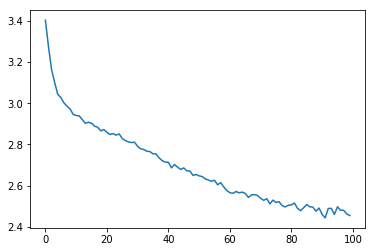

In [309]:
plt.plot(all_losses_gru)

收敛速度更慢了，比LSTM还慢

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [347]:
class RNN2(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        #for the first layer
        self.i2h0 = nn.Linear(self.input_size + self.hidden_size, self.hidden_size) #Linear layer
        #self.i2o0 = nn.Linear(self.input_size + self.hidden_size, self.output_size)
        # for other layers
        self.i2h = nn.Linear(self.hidden_size + self.hidden_size, self.hidden_size) #Linear layer
        self.i2o = nn.Linear(self.hidden_size + self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, input, hidden):
        """
        input -- a tensor shape of (1,n_letters)
        hidden -- a tensor shape of (n_layers,1,hidden_size)
        """
        #output = torch.zeros(self.num_layers,1,self.output_size)
        for layer in range(self.num_layers):
            if layer == 0: 
                combined = torch.cat((input,hidden[0]),1)
                hidden[layer] = self.i2h0(combined)
                #output = self.i2o0(combined) #第二个问题所在处
                #output = self.softmax(output)
            else: 
                combined = torch.cat((hidden[layer-1],hidden[layer]),1)
                hidden[layer] = self.i2h(combined)
                output = self.i2o(combined)
                output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers,1,self.hidden_size)

n_hidden = 128
n_layers = 3
rnn2 = RNN2(n_letters, n_hidden, n_categories,n_layers)

In [351]:
#Define training process
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_rnn2(category_tensor, line_tensor):
    rnn2.zero_grad() #每次梯度必须清零
    hidden = rnn2.initHidden()
    for i in range(line_tensor.size()[0]): #iteration for each letter
        output, hidden = rnn2(line_tensor[i], hidden)


    loss = criterion(output, category_tensor) #CrossEntropy loss
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate

    for name,p in rnn2.named_parameters(recurse=True):
        #print(name) 
        #print(p.grad)
        p.data.add_(-learning_rate, p.grad.data) # p=p-learning_rate*p.grad
    return output, loss.item()

In [353]:
#Train the model
import time
import math

n_iters =  20000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses_rnn2 = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    #print("categort:{},line:{},c_tensor:{},l_tensor:{}".format(category, line, category_tensor, line_tensor))
    output, loss = train_rnn2(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_rnn2.append(current_loss / plot_every)
        current_loss = 0

500 2% (0m 3s) 1.6473 Dinh / Chinese ✗ (Vietnamese)
1000 5% (0m 8s) 3.2217 Dominguez / Russian ✗ (Spanish)
1500 7% (0m 12s) 3.2947 Masin / Arabic ✗ (Italian)
2000 10% (0m 17s) 1.6999 Koury / Arabic ✓
2500 12% (0m 22s) 2.7070 Sauvageon / Russian ✗ (French)
3000 15% (0m 27s) 2.0750 Conchobhar / Irish ✓
3500 17% (0m 33s) 0.3910 Antonopoulos / Greek ✓
4000 20% (0m 38s) 2.4411 Schwartz / Polish ✗ (Czech)
4500 22% (0m 43s) 2.1681 Svejda / Portuguese ✗ (Czech)
5000 25% (0m 48s) 2.7737 Kattan / Irish ✗ (Arabic)
5500 27% (0m 52s) 3.0384 Hill / German ✗ (Scottish)
6000 30% (0m 58s) 2.4451 Wright / English ✗ (Scottish)
6500 32% (1m 3s) 2.2247 Szweda / Italian ✗ (Polish)
7000 35% (1m 8s) 0.7565 Yoo / Korean ✓
7500 37% (1m 13s) 1.5025 Perrault / French ✓
8000 40% (1m 18s) 2.1325 Braden / English ✗ (Irish)
8500 42% (1m 23s) 2.5669 Chevrolet / Dutch ✗ (French)
9000 45% (1m 28s) 5.7821 Kool / Korean ✗ (Dutch)
9500 47% (1m 33s) 1.9175 Demas / Portuguese ✗ (Greek)
10000 50% (1m 38s) 2.1136 Fonseca / Spa

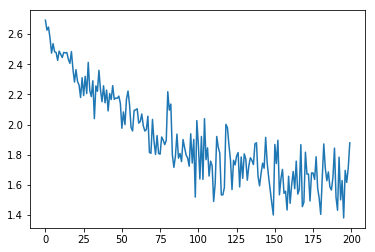

In [354]:
plt.plot(all_losses_rnn2)

多层的模型每轮次花的时间较多，所以只训练了10000轮，从时间的维度上看，收敛比基础模型要慢。

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

In [310]:
criterion = nn.NLLLoss()

In [322]:
import time
import math

n_iters = 200000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

learning_rate = 0.005
rnn = RNN(n_letters, n_hidden, n_categories)
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

RNN
1000 0% (0m 1s) 2.8965 Kreutschmer / German ✗ (Czech)
2000 1% (0m 2s) 2.8457 Rooijakker / German ✗ (Dutch)
3000 1% (0m 3s) 2.8546 Pokorny / English ✗ (Polish)
4000 2% (0m 4s) 2.8690 Hong / Chinese ✗ (Korean)
5000 2% (0m 6s) 3.1256 Jamussa / Japanese ✗ (Greek)
6000 3% (0m 7s) 2.7588 Oquendo / Portuguese ✗ (Spanish)
7000 3% (0m 8s) 2.8213 Zappa / Japanese ✗ (Italian)
8000 4% (0m 9s) 2.7382 Salib / Arabic ✓
9000 4% (0m 11s) 2.6535 Benitez / Dutch ✗ (Spanish)
10000 5% (0m 12s) 1.8268 Rotmistrov / Russian ✓
11000 5% (0m 13s) 3.0555 Gaspar / Arabic ✗ (Portuguese)
12000 6% (0m 14s) 1.2069 Rohmanov / Russian ✓
13000 6% (0m 16s) 3.0826 Fuchs / Greek ✗ (German)
14000 7% (0m 17s) 2.4973 Noble / French ✗ (English)
15000 7% (0m 18s) 1.9086 Addario / Italian ✓
16000 8% (0m 19s) 1.2928 Shadid / Arabic ✓
17000 8% (0m 20s) 3.0923 Stewart / French ✗ (Scottish)
18000 9% (0m 22s) 2.0869 Cunningham / Scottish ✓
19000 9% (0m 23s) 2.7184 Maradona / Japanese ✗ (Spanish)
20000 10% (0m 24s) 4.0531 Kuhn / Ch

166000 83% (3m 47s) 1.1519 Yun / Chinese ✗ (Korean)
167000 83% (3m 48s) 3.0397 Uerling / English ✗ (Czech)
168000 84% (3m 50s) 4.3981 Carruthers / Dutch ✗ (English)
169000 84% (3m 51s) 0.3151 Maloof / Arabic ✓
170000 85% (3m 53s) 0.5303 Luo / Chinese ✓
171000 85% (3m 54s) 2.3794 Han / Chinese ✗ (Korean)
172000 86% (3m 55s) 0.3965 Cloutier / French ✓
173000 86% (3m 57s) 0.0497 Kowalczyk / Polish ✓
174000 87% (3m 58s) 0.8048 Mitchell / Scottish ✓
175000 87% (4m 0s) 0.0056 Pyankov / Russian ✓
176000 88% (4m 1s) 3.1911 D'aramitz / Irish ✗ (French)
177000 88% (4m 3s) 0.4805 Iwahara / Japanese ✓
178000 89% (4m 4s) 0.7111 Hong / Korean ✓
179000 89% (4m 6s) 2.2459 Kennedy / English ✗ (Scottish)
180000 90% (4m 7s) 2.3892 Hout / French ✗ (Dutch)
181000 90% (4m 8s) 0.0423 Mosconi / Italian ✓
182000 91% (4m 10s) 5.0098 Tourna / Spanish ✗ (Greek)
183000 91% (4m 11s) 2.1131 Neil / Chinese ✗ (Irish)
184000 92% (4m 13s) 0.6074 Alves / Portuguese ✓
185000 92% (4m 15s) 1.8469 Young / Chinese ✗ (Scottish

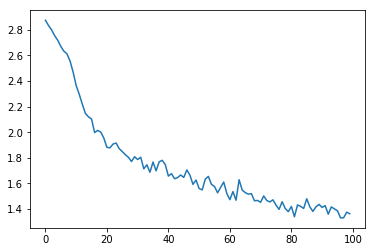

In [312]:
# 学习率0.005 跑 100000次的结果
plt.plot(all_losses)

与基础版的代码相比，同样学习率0.005同样的轮次100000，NLLoss的训练时间不到crossentropy的一半，当然，收敛情况稍差

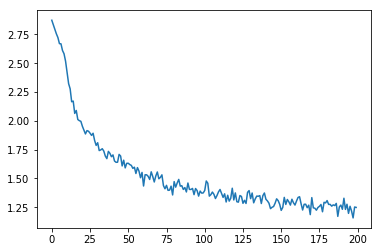

In [323]:
# 学习率0.005 跑 200000次的结果
plt.plot(all_losses)

与基础版代码相比，同样的学习率0.005，翻倍的轮次200000，NLLoss的训练时间和原来差不多，但收敛情况稍好